In [1]:
!pip install torch_frame

In [2]:
!pip install tensorboard

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Loading Data

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_y = train["Survived"]
train_x = train.drop(["Survived"], axis =1)
train_x.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


After the x and y are separated, we can call TensorDataset to convert the feature and labels into a dataset object that can be passed to a dataset loader.

In [5]:
# from torch.utils.data import TensorDataset
# dataset = TensorDataset(input, label)

### Data Preprocessing

In [6]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [7]:
num_features = [feature for feature in train.columns if train[feature].dtype != "O"]
num_features

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [8]:
num_features.remove("PassengerId")
num_features

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [9]:
object_features = [feature for feature in train.columns if train[feature].dtype == "O"]
object_features

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [10]:
train["Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [11]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [12]:
train["Ticket"].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [13]:
train.set_index("PassengerId")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### Handling Numerical Data

In [14]:
train[num_features].head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [15]:
train[num_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 41.9 KB


In [16]:
train["Age"].value_counts()

Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64

In [17]:
# train.hist(bins=50, figsize=(8,6))
# plt.show()

In [18]:
train[num_features].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
corr_matrix = train[num_features].corr()
corr_matrix["Survived"]

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [20]:
num_features.remove("Survived")

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
simple_imputer = IterativeImputer(max_iter=10, random_state = 42)
simple_imputer.fit(train[list(set(num_features)-set(["Fare"]))])
train_num_imputed = simple_imputer.transform(train[list(set(num_features)-set(["Fare"]))])
print(train_num_imputed)

[[ 3.          0.          1.         22.        ]
 [ 1.          0.          1.         38.        ]
 [ 3.          0.          0.         26.        ]
 ...
 [ 3.          2.          1.         21.03094419]
 [ 1.          0.          0.         26.        ]
 [ 3.          0.          0.         32.        ]]


In [22]:
num_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [23]:
train_num_df = pd.DataFrame(train_num_imputed, columns =list(set(num_features)-set(["Fare"])), index=train['PassengerId'])
train_num_df.head(5)

,Pclass,Parch,SibSp,Age
PassengerId,,,,
1,3.0,0.0,1.0,22.0
2,1.0,0.0,1.0,38.0
3,3.0,0.0,0.0,26.0
4,1.0,0.0,1.0,35.0
5,3.0,0.0,0.0,35.0


In [24]:
train_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    float64
 1   Parch   891 non-null    float64
 2   SibSp   891 non-null    float64
 3   Age     891 non-null    float64
dtypes: float64(4)
memory usage: 34.8 KB


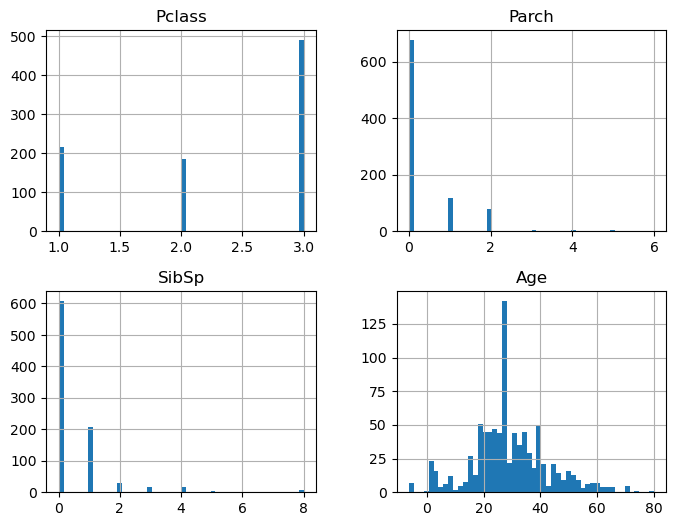

In [25]:
train_num_df.hist(bins=50, figsize=(8,6))
plt.show()

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

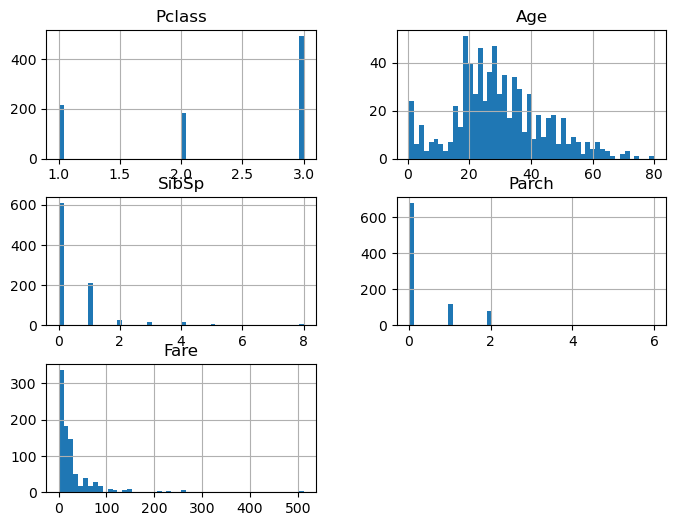

In [26]:
train[num_features].hist(bins=50, figsize=(8,6))

In [27]:
corr_matrix["Age"]

Survived   -0.077221
Pclass     -0.369226
Age         1.000000
SibSp      -0.308247
Parch      -0.189119
Fare        0.096067
Name: Age, dtype: float64

#### Estimator for Handling NaN Values

In [31]:
num_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [51]:
input_age = train[num_features]
input_age = input_age.dropna(subset=["Age"], axis = 0)
age = input_age["Age"]
input_age = input_age.drop(["Age"], axis = 1)
input_age.head(5)

,Pclass,SibSp,Parch,Fare
0,3,1,0,7.2500
1,1,1,0,71.2833
2,3,0,0,7.9250
3,1,1,0,53.1000
4,3,0,0,8.0500


In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

scaler = MinMaxScaler()
selected_scaler = ColumnTransformer([
    ("min_max", scaler, ["Fare"])
], remainder="passthrough").set_output(transform="pandas")
input_age = selected_scaler.fit_transform(input_age)
input_age

,min_max__Fare,remainder__Pclass,remainder__SibSp,remainder__Parch
0,0.014151,3,1,0
1,0.139136,1,1,0
2,0.015469,3,0,0
3,0.103644,1,1,0
4,0.015713,3,0,0
...,...,...,...,...
885,0.056848,3,0,5
886,0.025374,2,0,0
887,0.058556,1,0,0
889,0.058556,1,0,0


array([[<Axes: title={'center': 'min_max__Fare'}>,
        <Axes: title={'center': 'remainder__Pclass'}>],
       [<Axes: title={'center': 'remainder__SibSp'}>,
        <Axes: title={'center': 'remainder__Parch'}>]], dtype=object)

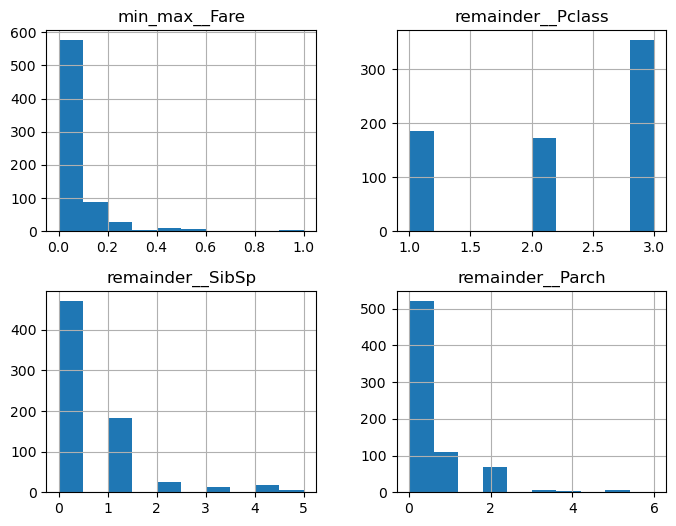

In [53]:
input_age.hist(figsize=(8,6))

In [57]:
from sklearn.model_selection import train_test_split

train_age_x, test_age_x, train_age_y, test_age_y = train_test_split(input_age, train["Age"].dropna(), test_size = 0.2, random_state=42)
print(len(train_age_x))
print(len(test_age_x))


571
143


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

random_forest = RandomForestRegressor()
random_forest.fit(train_age_x, train_age_y)
pred = random_forest.predict(test_age_x)

error = mse(pred,test_age_y)
error


139.8425973301796